<a href="https://colab.research.google.com/github/omprabhu98/MEngCapstone2022/blob/main/Sensor_Fusion_Camera_and_Radar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Packages

In [1]:
# Tensorflow
import tensorflow.compat.v1 as tf
print(tf.__version__)

# I/O libraries
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

# Helper libraries
import matplotlib
import torch
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2 as cv
from tqdm import tqdm
import IPython
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Comment this out if you want to see Deprecation warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
#test


2.13.0


In [2]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 34.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 MB/s eta 0:00:00


# Functions for Image Segmentation

In [3]:
class DeepLabModel(object):
    """Class to load deeplab model and run inference."""

    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        graph_def = None

        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():
            tf.import_graph_def(graph_def, name='')
        self.sess = tf.Session(graph=self.graph)

    def run(self, image, INPUT_TENSOR_NAME = 'ImageTensor:0', OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'):
        """Runs inference on a single image.

        Args:
            image: A PIL.Image object, raw input image.
            INPUT_TENSOR_NAME: The name of input tensor, default to ImageTensor.
            OUTPUT_TENSOR_NAME: The name of output tensor, default to SemanticPredictions.

        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        target_size = (2049,1025)  # size of Cityscapes images
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            OUTPUT_TENSOR_NAME,
            feed_dict={INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]  # expected batch size = 1
        if len(seg_map.shape) == 2:
            seg_map = np.expand_dims(seg_map,-1)  # need an extra dimension for cv.resize
        seg_map = cv.resize(seg_map, (width,height), interpolation=cv.INTER_NEAREST)
        return seg_map

In [4]:
def create_label_colormap():
    """Creates a label colormap used in Cityscapes segmentation benchmark.

    Returns:
        A Colormap for visualizing segmentation results.
    """
    colormap = np.array([
        [128,  64, 128],
        [244,  35, 232],
        [ 70,  70,  70],
        [102, 102, 156],
        [190, 153, 153],
        [153, 153, 153],
        [250, 170,  30],
        [220, 220,   0],
        [107, 142,  35],
        [152, 251, 152],
        [ 70, 130, 180],
        [220,  20,  60],
        [255,   0,   0],
        [  0,   0, 142],
        [  0,   0,  70],
        [  0,  60, 100],
        [  0,  80, 100],
        [  0,   0, 230],
        [119,  11,  32],
        [  0,   0,   0]], dtype=np.uint8)
    return colormap


def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
            is the color indexed by the corresponding element in the input label
            to the PASCAL color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
            map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]


def vis_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(20, 4))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')

    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(seg_map).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid('off')
    plt.show()


LABEL_NAMES = np.asarray([
    'road', 'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle', 'void'])

COLOR_MAP = np.array([
    [128,  64, 128],
    [244,  35, 232],
    [ 70,  70,  70],
    [102, 102, 156],
    [190, 153, 153],
    [153, 153, 153],
    [250, 170,  30],
    [220, 220,   0],
    [107, 142,  35],
    [152, 251, 152],
    [ 70, 130, 180],
    [220,  20,  60],
    [255,   0,   0],
    [  0,   0, 142],
    [  0,   0,  70],
    [  0,  60, 100],
    [  0,  80, 100],
    [  0,   0, 230],
    [119,  11,  32],
    [  0,   0,   0]], dtype=np.uint8)

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

In [5]:
MODEL_NAME = 'mobilenetv2_coco_cityscapes_trainfine'
#MODEL_NAME = 'xception65_cityscapes_trainfine'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_trainfine':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'xception65_cityscapes_trainfine':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME], download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


# Initialize Midas

In [6]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:11<00:00, 117MB/s]


In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

In [8]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [9]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [10]:
!git clone https://github.com/Mmengyw/Capstone-Updated.git
!ls
os.chdir("Capstone-Updated/Videos")

Cloning into 'Capstone-Updated'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 246 (delta 13), reused 23 (delta 13), pack-reused 222
Receiving objects: 100% (246/246), 217.56 MiB | 43.97 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Capstone-Updated  sample_data


# Conversion to meters

In [11]:
nb_photo=34

equiv=[[0.001,51],    #for extrapolation
      [0.1,45],     #premier plan
      [0.9,42.3],
      [1.8,37.4],
      [2.7,28.7],
      [3.6,24.443365],
      [4.5,22.058018],
      [5.4,15.317413],
      [6.3,14.677493],
      [7.2,10.969739],
      [8.1,10.883035],
      [9,9.883035],
      [9.9,8.058806],
      [10.8,7.5158963],
      [11.7,7.098169],
      [12.6,6.111024],
      [13.5,5.6323136],
      [14.4,5.2216917],
      [15.3,5],
      [16.2,4.9529667],
      [17.1,4.8],
      [18,4.7],
      [18.9,4.6],
      [19.8,4.5],
      [20.7,4.4],
      [21.6,4.3],
      [22.5,4.2],
      [23.4,4.1],
      [24.3,4],
      [25.2,3.9],
      [26.1,3.8],
      [27,3.7],
      [27.9,3.6],
      [28.8,3.5],
      [29.7,3.2],
      [30.6,3],
      [60,0.0],

      [120,-6],    #horizon

      [40,1.98],
      [50,1.33]

       ]   #for extrapolation

#=========================================================================================

equiv2=[[1,41.05157], #1yard  0302
        [1,42.18351],
        [1,31.304607],
        [1,25.090006],
        [1,23.275448], #5yard 0306
        [1,19.171278],
        [1,17.472866],
        [1,16.775742],
        [1,15.820402],
        [1,15.538459], #10yard  0311
        [1,14.466544],
        [1,12.707126],
        [1,10.957558],


        [1,6.023936],#'''inacurrate'''
        [1,9.797453],  #15yard 0316
        [1,7.2150397],
        [1,6.3944836],
        [1,8.514687],
        [1,7.735209],
        ]

In [12]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf, InterpolatedUnivariateSpline
equiv=np.asarray(equiv)
X = equiv[:,1]    #midas output
Y=equiv[:,0]     #meters
new_length = 25
new_x = np.linspace(X.min(), X.max(), new_length)
conv=sp.interpolate.interp1d(X, Y, kind='linear')

#Increased contrast
Just to get increased contrast, not values in meters

In [13]:
coef_expand=[[-5,-1],
        [1,10],
        [5,25],
        [10,35],
        [15,42],
        [35,43],
        [45,50],
        [51,51]
        ]
coef_expand=np.asarray(coef_expand)
X = coef_expand[:,0]    #midas output
Y=coef_expand[:,1]      #meters
expand=sp.interpolate.interp1d(X, Y, kind='cubic')

# Segmented Point Cloud

In [14]:
from math import sin,cos,atan2
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
def depth2pcd_segm(depth,seg_map):
    # print(depth)
    # print(seg_map)
    width = depth.shape[1]
    height = depth.shape[0]
    # print(width)
    # print(height)
    fx= 926.9796142578125
    fy= 924.431884765625
    cx= 790.234375
    cy= 617.5499267578125
    points = []
    objects_needed = {'sidewalk', 'building', 'wall', 'fence', 'pole', 'traffic light',
    'traffic sign', 'vegetation', 'terrain', 'person', 'rider', 'car', 'truck',
    'bus', 'train', 'motorcycle', 'bicycle'}
    objects_car = {'car'}
    objects_wanted = {'car', 'trees','sidewalk'}


    for v in range(0, width, 5):
        # for u in range(0, height, 2):
        for u in range(0, 1000, 5):
            R = depth[u][v]
            color = seg_map[u][v]
            # print(R)
            # print(color)
            if R == 0:
                continue

            X_cam = (v - cx)
            Y_cam = -(u - cy)

            theta_x = atan2(X_cam,fx)
            theta_y = atan2(Y_cam,fy)

            X = R*cos(theta_y)*sin(theta_x)
            Y = R*cos(theta_x)*sin(theta_y)
            Z = R*cos(theta_x)*cos(theta_y)

            if LABEL_NAMES[color] in objects_wanted:
              # points.append([X, Y, Z])
              points.append([X, Y, Z,color])
            # points.append([X, Y, Z,color])

    return np.array(points)

In [15]:
def prediction_stream(image, seg_map, seg_data, frame, index):
    """Visualizes segmentation overlay view and stream it with IPython display."""
    for i in range(len(seg_map)):
        for j in range(len(seg_map[i])):
                seg_data[i][j] = LABEL_NAMES[seg_map[i][j]]



    img = frame
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
      prediction = midas(input_batch)

      prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
      ).squeeze()

    output = prediction.cpu().numpy()
    output = (output > 0) * output
    distanceGuess = 2
    alpha = output[output.shape[0]-10, int(output.shape[1]*3/4)]*distanceGuess
    # output=expand(50*output/np.max(output)) # for better visualization
    # output=conv(50*output/np.max(output))
    output = alpha/(output+.001)
    # print(output) # to get values in meters

    # plt.imshow(output, cmap='plasma')

    pc_3d = depth2pcd_segm(output,seg_map)
    # if len(pc_3d) == 0:
    #   fig = plt.figure(figsize=(12,6))
    # else:
    #   x = pc_3d[:, 0]
    #   y = pc_3d[:, 1]
    #   z = pc_3d[:, 2]
    #   color = pc_3d[:, 3]
    #   color_plot = np.zeros((len(color),3))
    #   for i in range(len(color)):
    #     color_plot[i] = COLOR_MAP[int(color[i])]

    #   fig = plt.figure(figsize=(12,6))
      # pc3dd = np.array([[x[i], z[i]] for i in range(len(x))])
      # km = KMeans(n_clusters = 4)
      # clusters= km.fit_predict(pc3dd)
      # centroids = km.cluster_centers_
      # points = np.empty((0,len(pc3dd[0])), float)
      # # distances will be used to calculate outliers
      # distances = np.empty((0,len(pc3dd[0])), float)
      # # getting points and distances
      # for i, center_elem in enumerate(centroids):
      #     # cdist is used to calculate the distance between center and other points
      #     distances = np.append(distances, cdist([center_elem],pc3dd[clusters == i], 'euclidean'))
      #     points = np.append(points, pc3dd[clusters == i], axis=0)
      # percentile = 90
      # # getting outliers whose distances are greater than some percentile
      # outliers = points[np.where(distances > np.percentile(distances, percentile))]
      # #plotting outliers
      # pc3dlast = C = np.array(list(filter(lambda x: x not in outliers, pc3dd)))
      # plt.scatter(pc3dlast[:,0],pc3dlast[:,1],s=0.1)
    #   plt.scatter(x,z,c=color_plot/255,s=0.1)
    # plt.xlabel('Z')
    # plt.ylabel('X')
    # plt.xlim(-30, 30)
    # plt.ylim(0, 30)

    # plt.savefig('saved_figure.jpg')
    # im = cv.imread('saved_figure.jpg')
    # frames.append(im)
    # plt.close()
    # plt.imshow(expand(output), cmap='plasma')
    # A = np.stack([seg_data,output])
    # A = np.stack([seg_map,output])

    # # Show visualization in a streaming fashion.
    # f = BytesIO()
    # plt.savefig(f, format='jpeg')
    # IPython.display.display(IPython.display.Image(data=f.getvalue()))
    # f.close()
    # plt.close()
    return pc_3d
def prediction_video(frame, index):
    """Inferences DeepLab model on a video file and stream the visualization."""
    original_im = Image.fromarray(frame[..., ::-1])
    seg_map = MODEL.run(original_im)
    seg_data = np.full((len(seg_map),len(seg_map[0])),'nullvoidnada')
    filled_seg_data = prediction_stream(original_im, seg_map, seg_data, frame, index)
    # print(filled_seg_data)
    return filled_seg_data

In [16]:
# Get Map of Time frames of SAR to Camera, by finding nearest frames

import pickle
# os.chdir("Capstone-Updated/SAR+Camera_Fusion")

with open('camera_times.pickle', 'rb') as file:
    camera_times = pickle.load(file)

with open('sar_tracklog.pickle', 'rb') as file:
    SAR_tracklog = pickle.load(file)

SAR_tracklog = np.array(SAR_tracklog)
SAR_times = SAR_tracklog[:,0]

timestamp_map = np.zeros(len(SAR_times))

j=0
for i in range(len(SAR_times)):
  while camera_times[j]<SAR_times[i]:
    j+=1
  timestamp_map[i] = j
# print(timestamp_map)

<ipython-input-16-e88d1a3e1d0b>:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  SAR_tracklog = np.array(SAR_tracklog)


In [17]:
frames = []
pc3darray = []
# SAMPLE_VIDEO = 'camera30fps.mp4'
SAMPLE_VIDEO = 'camera.mp4'
print('running deeplab on the sample video...')

video = cv.VideoCapture(SAMPLE_VIDEO)
# num_frames = 598  # uncomment to use the full sample video
num_frames = 200

try:
    for i in range(num_frames):
        _, frame = video.read()
        if not _: break
        print(i)
        filled_seg_DATA = prediction_video(frame, int(timestamp_map[i]))
        pc3darray.append(filled_seg_DATA)
        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")
# print(filled_seg_DATA)


# height, width, layers = frames[0].shape
# size = (width,height)
# fourcc = cv.VideoWriter_fourcc(*'MJPG')
# out = cv.VideoWriter('new_3D_pointcloud_wanted.avi', fourcc, 30.0, size)

# for i in range(len(frames)):
#     out.write(frames[i])
# out.release()

# pc3darray = np.array(pc3darray)

199


# Convert Camera Frame to SAR frame

In [18]:
#Transform a point [X,Y,Z] from the camera frame to the car frame (SAR)
def Cam_ref_2_Car_ref(Pos_obj_cam):
    #camera extrinsic (quaternion, translation)
    R=[[ 0.99994752,  0.00325207,  0.00971481],
    [-0.0030831 ,  0.99984459, -0.01735761],
    [-0.00976975,  0.01732675,  0.99980215]]

    T=[-0.41649988293647766, 0.09146018326282501, 0.011436160653829575]

    Pos_obj_car = R@Pos_obj_cam[:3] + T
    Pos_obj_car = np.append(Pos_obj_car,[Pos_obj_cam[-1]])
    return Pos_obj_car

In [19]:
pc3darray_SAR_frame = []

for i in range(len(pc3darray)):
  pointcloud = []
  for j in range(len(pc3darray[i])):
    pointcloud.append(Cam_ref_2_Car_ref(pc3darray[i][j]))
  pc3darray_SAR_frame.append(pointcloud)

# print(Cam_ref_2_Car_ref(pc3darray[10]))

pc3darray_SAR_frame = np.array(pc3darray_SAR_frame)

<ipython-input-19-e9a5f79602fa>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pc3darray_SAR_frame = np.array(pc3darray_SAR_frame)


[-10.0594986   -1.6534918   11.51367973   1.        ]
1.0
[244  35 232]


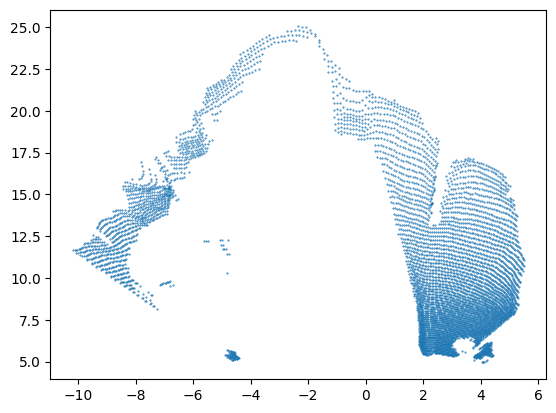

In [20]:
coord = np.array(pc3darray_SAR_frame[39])
print(coord[1])
plt.scatter(coord[:,0],coord[:,2],s = 0.2)
print(coord[1,3])
print(COLOR_MAP[int(coord[1,3])])

In [21]:
col = set(coord[:,3])
print(col)

{1.0, 13.0}


# SAR Video Processing

In [22]:
import cv2 as cv
import IPython
import matplotlib.pyplot as plt
from PIL import Image
from google.colab.patches import cv2_imshow
import numpy as np
from io import BytesIO

# from google.colab import drive
# drive.mount('/content/drive')

# SHRAVANs DRIVE
# !ls "/content/drive/My Drive/Capstone/SAR_data"

RADAR_VIDEO = 'radar_sar.mp4'
CAMERA_VIDEO = 'camera.mp4'

# # OMs DRIVE
# !ls "/content/drive/My Drive/Capstone/SAR_data"

# RADAR_VIDEO = '/content/drive/My Drive/Capstone/SAR_data/radar_sar.mp4'
# CAMERA_VIDEO = '/content/drive/My Drive/Capstone/SAR_data/camera.mp4'

In [23]:
def Convert_to_Meters(frame):
  center_x = 625
  center_y = 624
  height, width = frame.shape

  points = []

  for v in range(0, width):
        for u in range(0, height):
          if frame[u][v]<200:
            x = (v-center_x)*0.04
            y = -(u-center_y)*0.04
            points.append([x,y])
  return np.array(points)

In [24]:
def GetThreshold_Binary(frame):
  gray_scale = 255 - cv.cvtColor(frame,cv.COLOR_RGB2GRAY)
  threshold = 0.9*np.max(gray_scale)
  _, thres = cv.threshold(gray_scale, threshold, 255,cv.THRESH_BINARY)
  point_cloud = Convert_to_Meters(thres)
  point_cloud = np.array(point_cloud)

  # fig = plt.figure(figsize=(12,6))
  # plt.scatter(point_cloud[:,0],point_cloud[:,1],s=0.1)
  # plt.xlabel('Z')
  # plt.ylabel('X')
  # plt.xlim(-25, 25)
  # plt.ylim(0, 25)

  # plt.savefig('saved_figure.jpg')
  # im = cv.imread('saved_figure.jpg')
  # frames.append(im)
  # plt.close()

  return thres, point_cloud

In [25]:
def GetThreshold_Adaptive(frame):
  gray_scale = 255 - cv.cvtColor(frame,cv.COLOR_RGB2GRAY)
  thres = cv.adaptiveThreshold(gray_scale,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,10)
  point_cloud = Convert_to_Meters(thres)
  point_cloud = np.array(point_cloud)

  # fig = plt.figure(figsize=(12,6))
  # plt.scatter(point_cloud[:,0],point_cloud[:,1],s=0.1)
  # plt.xlabel('Z')
  # plt.ylabel('X')
  # plt.xlim(-25, 25)
  # plt.ylim(0, 25)

  # plt.savefig('saved_figure.jpg')
  # im = cv.imread('saved_figure.jpg')
  # frames.append(im)
  # plt.close()

  return thres, point_cloud

In [26]:
def GetThreshold_Gaussian(frame):
  gray_scale = 255 - cv.cvtColor(frame,cv.COLOR_RGB2GRAY)
  thres = cv.adaptiveThreshold(gray_scale,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,21,10)
  point_cloud = Convert_to_Meters(thres)
  point_cloud = np.array(point_cloud)

  # fig = plt.figure(figsize=(12,6))
  # plt.scatter(point_cloud[:,0],point_cloud[:,1],s=0.1)
  # plt.xlabel('Z')
  # plt.ylabel('X')
  # plt.xlim(-25, 25)
  # plt.ylim(0, 25)

  # plt.savefig('saved_figure.jpg')
  # im = cv.imread('saved_figure.jpg')
  # frames.append(im)
  # plt.close()

  return thres, point_cloud

In [27]:
def Plot_Camera_with_SAR(point_cloud_SAR, point_cloud_Camera):

  fig = plt.figure(figsize=(12,6))
  plt.scatter(point_cloud_SAR[:,0],point_cloud_SAR[:,1],s=0.1, color = 'black')

  if len(point_cloud_Camera)>0:
    color = (point_cloud_Camera[:, 3])
    color_plot = np.array([COLOR_MAP[int(c)] for c in color])
    # print(color_plot)
    plt.scatter(point_cloud_Camera[:,0],point_cloud_Camera[:,2],s=0.1 , color = color_plot/255)
  plt.xlabel('Z')
  plt.ylabel('X')
  plt.xlim(-25, 25)
  plt.ylim(0, 25)

  plt.savefig('saved_figure.jpg')
  im = cv.imread('saved_figure.jpg')
  frames.append(im)
  plt.close()
  return

In [29]:
frames=[]
video_radar = cv.VideoCapture(RADAR_VIDEO)
# num_frames = 200


A = np.zeros((num_frames,624,1250))

SAR_points = []

try:
    for i in range(num_frames):
        _, frame = video_radar.read()
        if not _: break
        print(i)
        A[i], points_SAR= GetThreshold_Binary(frame)
        # A[i], points_SAR = GetThreshold_Adaptive(frame)
        # A[i], points_SAR = GetThreshold_Gaussian(frame)

        points_camera = np.array(pc3darray_SAR_frame[i])
        Plot_Camera_with_SAR(points_SAR, points_camera)
        SAR_points.append(points_SAR)

        IPython.display.clear_output(wait=True)
except KeyboardInterrupt:
    plt.close()
    print("Stream stopped.")


height, width, layers = frames[0].shape
size = (width,height)
fourcc = cv.VideoWriter_fourcc(*'MJPG')
out = cv.VideoWriter('SARandCamera_pointcloud.avi', fourcc, 30.0, size)

for i in range(len(frames)):
    out.write(frames[i])
out.release()


SAR_points = np.array(SAR_points)

Stream stopped.


<ipython-input-29-ab0652af5318>:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  SAR_points = np.array(SAR_points)
